##Анализ RMC###

###Кластеры###


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from SS.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LinearRegression

In [31]:
df_clusters = pd.read_csv('Merged_data.csv', sep = ',').rename(columns={'Unnamed: 0': 'Old_numbers'})
df_united = pd.read_csv('df_united.csv', sep = ';')

In [33]:
temp = df_clusters.pop('ID_client')
df_clusters.insert(0, 'ID_client', temp)
temp = df_clusters.pop('Old_numbers')
df_clusters.insert(8, 'Old_numbers', temp)

In [34]:
def lint(x):
  return int(x)

df_clusters['ExpLog_y'] = list(map(lint, df_clusters['ExpLog_y']))

In [35]:
clusters = []
gr = df_clusters.groupby('Cluster')
for key, item in gr:
  clusters.append(gr.get_group(key))

In [36]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [67]:
results_imp = []
results_ind = []
scores_disc = []

for cluster in clusters:

  X = cluster.drop(columns = {'ID_client', 'Year', 'Region_x', 'Shop_x', 'Card', 'Expences_x', 'Date',
       'Discount_x', 'Old_numbers', 'Age_x', 'ExpLog_x','Cluster', "ExpLog_y", "Expences_y"})
  Y = cluster['ExpLog_y'].values

  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

  RMC_model = RandomForestClassifier(n_estimators = 100)
  RMC_model.fit(X_train, Y_train)

  importances = RMC_model.feature_importances_
  results_imp.append(importances)
  results_ind.append(np.argsort(importances)[::-1])

  print("F1 score:",metrics.f1_score(Y_test, RMC_model.predict(X_test), average = 'micro'))

  scores_disc.append(metrics.f1_score(Y_test, RMC_model.predict(X_test), average = 'micro'))

F1 score: 0.3242630385487528
F1 score: 0.25080238422741863
F1 score: 0.269774011299435
F1 score: 0.3704873646209386


In [39]:
col = cluster.drop(columns = {'ID_client', 'Year', 'Region_x', 'Shop_x', 'Card', 'Expences_x', 'Date',
       'Discount_x', 'Old_numbers', 'Age_x', 'ExpLog_x','Cluster', "ExpLog_y", "Expences_y"}).columns
for importances, indices in zip(results_imp, results_ind):
  ar_f = []
  for f, idx in enumerate(indices):
      ar_f.append([round(importances[idx],4), col[idx]])
  for i in ar_f:
      if(i[1] == "Discount_y"):           
        print(i)

[0.0446, 'Discount_y']
[0.0186, 'Discount_y']
[0.0259, 'Discount_y']
[0.0355, 'Discount_y']


0 Cluster
1 Cluster
2 Cluster
3 Cluster


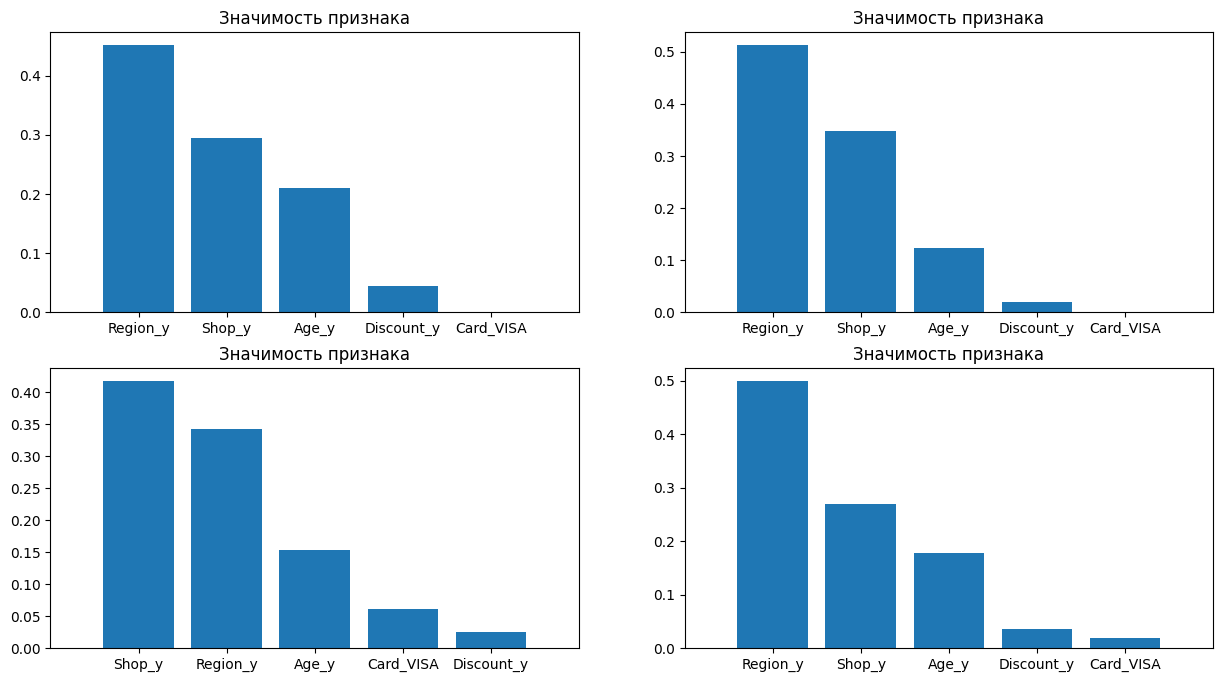

In [40]:
n_cl = 0
n = 2
en = 0
c = 0
figure, axis = plt.subplots(n, 2, figsize=(15, 8))

for importances, indices in zip(results_imp, results_ind):
  n_cl+=1
  d_first = len(col)
  axis[c, en].set_title("Значимость признака")
  axis[c, en].bar(range(d_first), importances[indices[:d_first]], align='center')
  axis[c, en].set_xticks(ticks=range(d_first), labels=np.array(col)[indices[:d_first]])
  axis[c, en].set_xlim([-1, d_first])
  
  if en == 1:
    c += 1
    en = 0
  else:
    en += 1

In [41]:
results_imp = []
results_ind = []
scores_nodisc = []

for cluster in clusters:
  X = cluster.drop(columns = {'ID_client', 'Year', 'Region_x', 'Shop_x', 'Card', 'Expences_x', 'Date',
       'Discount_x', 'Old_numbers', 'Age_x', 'ExpLog_x','Cluster', "ExpLog_y", "Expences_y", 'Discount_y'})
  Y = cluster['ExpLog_y'].values
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
  RMC_model = RandomForestClassifier(n_estimators = 100)
  RMC_model.fit(X_train, Y_train)

  importances = RMC_model.feature_importances_
  results_imp.append(importances)
  results_ind.append(np.argsort(importances)[::-1])

  print("F1 score:",metrics.f1_score(Y_test, RMC_model.predict(X_test), average = 'micro'))
  scores_nodisc.append(metrics.f1_score(Y_test, RMC_model.predict(X_test), average = 'micro'))

F1 score: 0.32335600907029477
F1 score: 0.24300779458963778
F1 score: 0.2730696798493409
F1 score: 0.3646209386281589


In [45]:
from scipy.stats import norm
import scipy. stats as stats 
import statistics as st
import scipy as sp
import numpy as np
def pooled_standard_error(a, b, unbias=False):
    std1 = np.std(a) if unbias==False else a.std() 
    std2 = np.std(b) if unbias==False else b.std()
    x = std1 ** 2 / len(a)
    y = std2 ** 2 / len(b)
    return np.sqrt(x + y)

def z_stat(a, b, unbias=False):
    return (st.mean(a) - st.mean(b)) / pooled_standard_error(a, b, unbias)

def z_test(a, b): 
    return norm.cdf([ z_stat(a, b) ])



print('z-статистика:', round(z_stat(scores_disc, scores_nodisc), 4))
print('p-значение:', z_test(scores_disc, scores_nodisc))
#P-value is greater than 5% -> we can't say that diff is not statiscally important

z-статистика: 0.0262
p-значение: [0.5104313]


In [46]:
stats.ttest_ind(a=scores_disc, b=scores_nodisc) 

Ttest_indResult(statistic=0.0226468884941088, pvalue=0.9826663157736257)

In [72]:
from scipy.stats import mannwhitneyu
stat, p = mannwhitneyu(scores_disc,scores_nodisc)
print("MannWhitneyu:", p)

MannWhitneyu: 0.8857142857142857


<ipython-input-60-82bf9d32280b>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = cl1.corr()
<ipython-input-60-82bf9d32280b>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = cl1.corr()
<ipython-input-60-82bf9d32280b>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = cl1.corr()
<ipython-input-60-82bf9d32280b>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid co

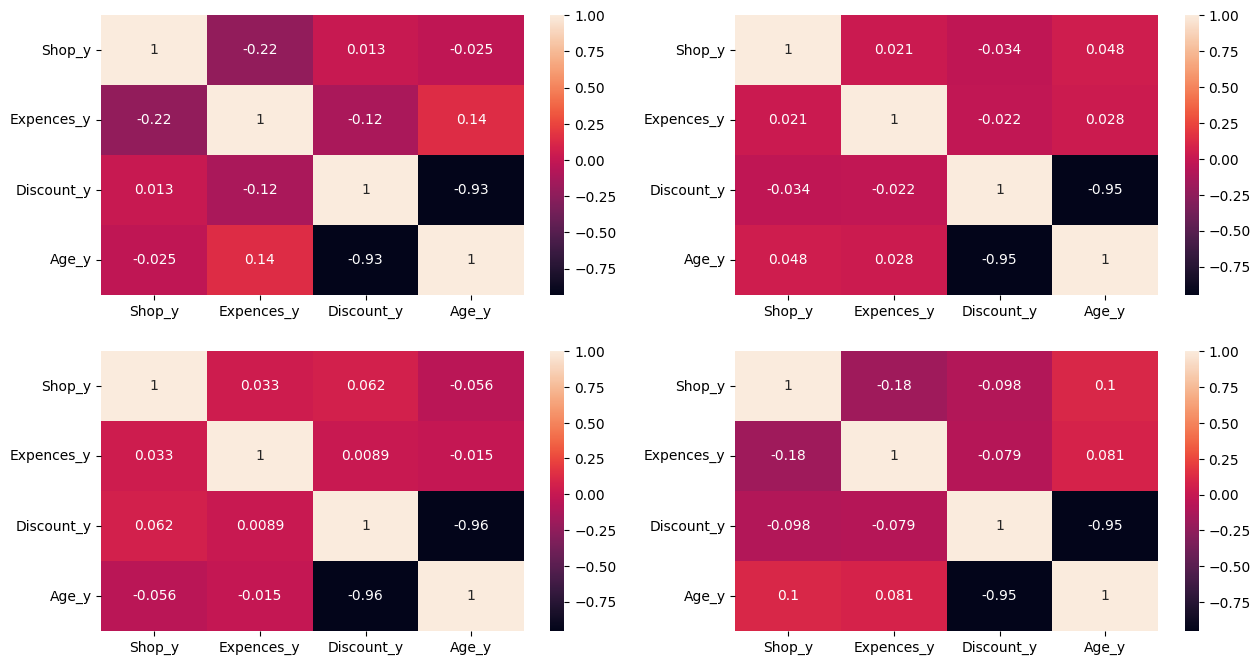

In [60]:
c = 0
n = 2
en = 0
figure, axis = plt.subplots(n, 2, figsize=(15, 8))
for i in clusters:
  cl1 = i.drop(columns = {'ID_client', 'Year', 'Region_x', 'Shop_x', 'Expences_x', 'Date',
'Discount_x', 'Old_numbers', 'Age_x', 'ExpLog_x','Cluster', "ExpLog_y", 'Region_y', 'Card_VISA'})
  corr = cl1.corr()
  sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True,
            ax = axis[c, en])
  
  if en == 1:
    c += 1
    en = 0
  else:
    en += 1

In [74]:
d = df_united.drop(columns = {'Year', 'ID_client'})
df_grouped = d.groupby(["Region", "Shop"])
reg_rec_age = {}

for key, item in df_grouped:
    temp = {}
    a = df_grouped.get_group(key)
    b = a.groupby("Age")
    max_spend = 0
    for key1, item in b:
      temp[key1] = b.get_group(key1)['Spending'].sum()
    #print(key1, max(temp.values()))
    reg_rec_age[key] = key1

In [63]:
title = ""
for (region, shop), v in reg_rec_age.items():
  if title != region:
    print("\n-----", region, "-----")
  if(shop != "None"):
    print(":: for ", shop, " Recomended age - ", v)
  title = region


----- None -----
:: for  Бар "Коктейль"  Recomended age -  28

----- Алтайский край -----
:: for  Автотранспорт  Recomended age -  23
:: for  Алкогольный магазин  Recomended age -  23
:: for  Бар "Коктейль"  Recomended age -  33
:: for  Барбершоп  Recomended age -  23
:: for  Перевод денег на депозит  Recomended age -  20
:: for  Покупка одежды  Recomended age -  32
:: for  Покупка техники  Recomended age -  32
:: for  Покупки Ozon  Recomended age -  23
:: for  Ресторан "Буйвол"  Recomended age -  32
:: for  Салон красоты  Recomended age -  32
:: for  Такси  Recomended age -  23
:: for  Турагенство  Recomended age -  25

----- Амурская область -----
:: for  Алкогольный магазин  Recomended age -  40
:: for  Бар "Коктейль"  Recomended age -  40
:: for  Барбершоп  Recomended age -  40
:: for  Покупка одежды  Recomended age -  40
:: for  Покупки Ozon  Recomended age -  40
:: for  Ресторан "Буйвол"  Recomended age -  40
:: for  Салон красоты  Recomended age -  40
:: for  Такси  Recomended 

<ipython-input-70-80a3be0195fe>:14: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for key, value in time_gr:


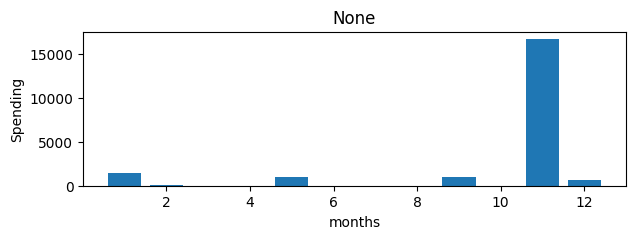

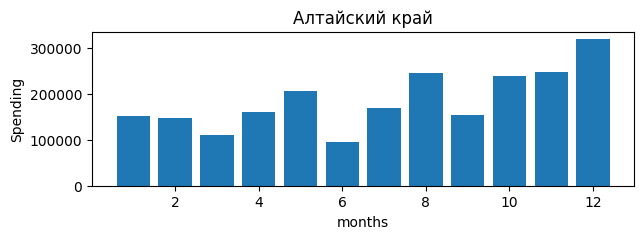

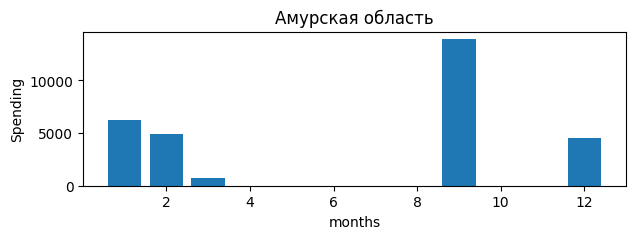

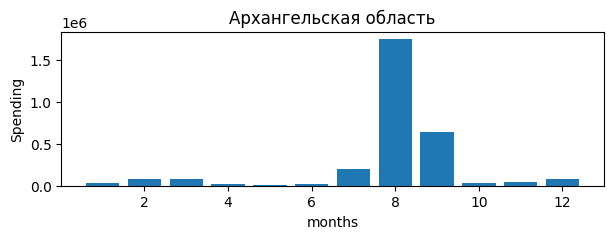

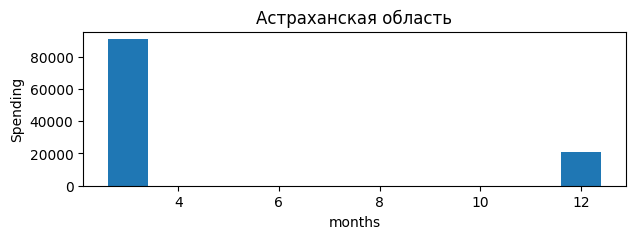

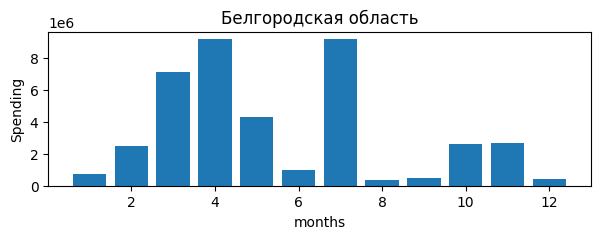

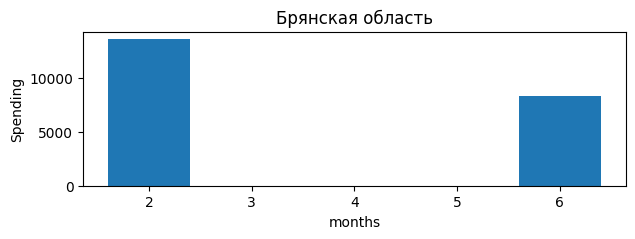

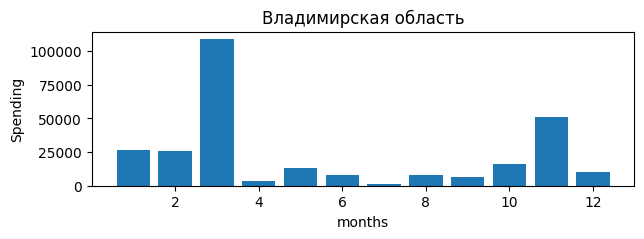

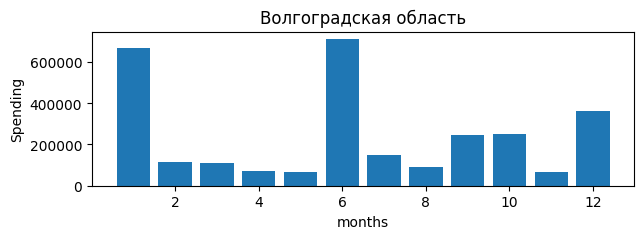

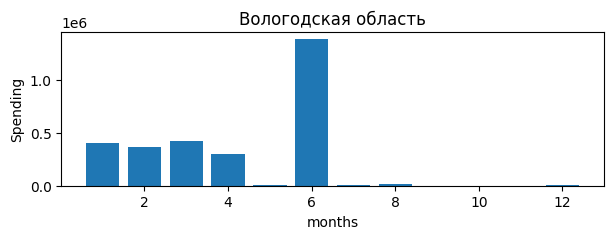

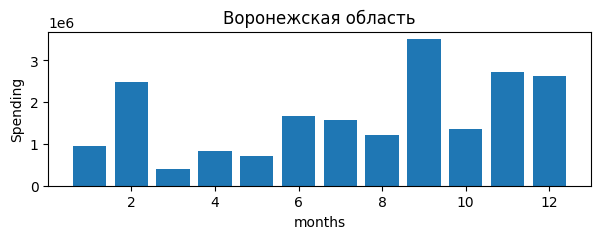

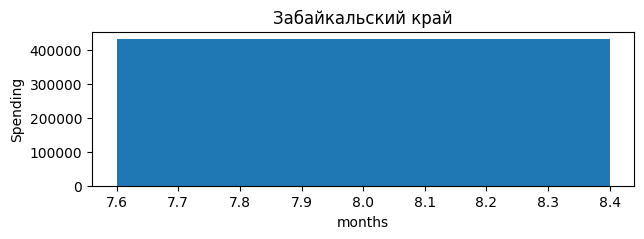

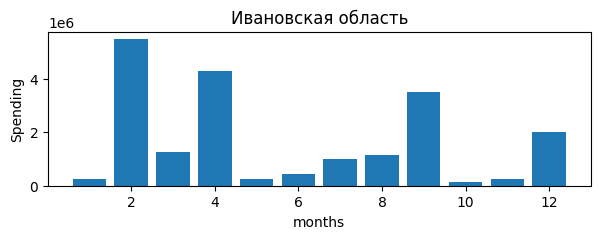

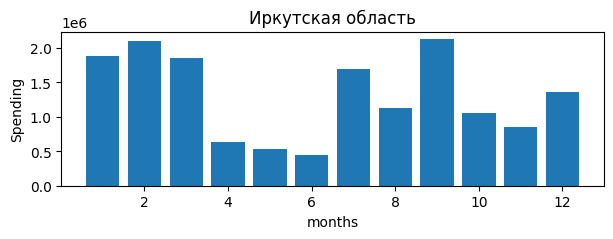

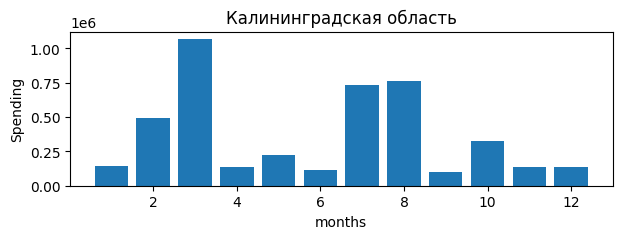

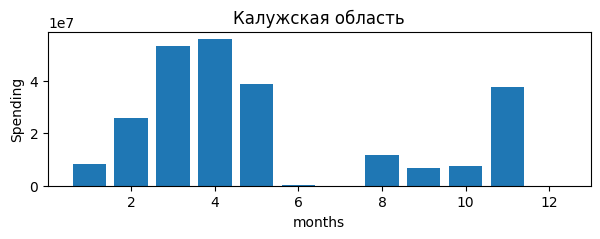

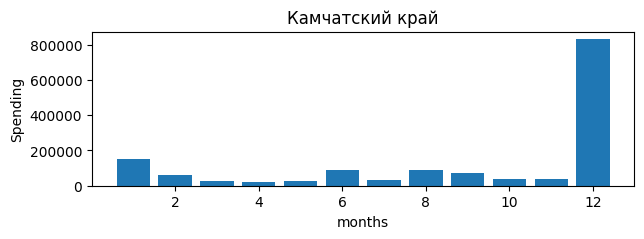

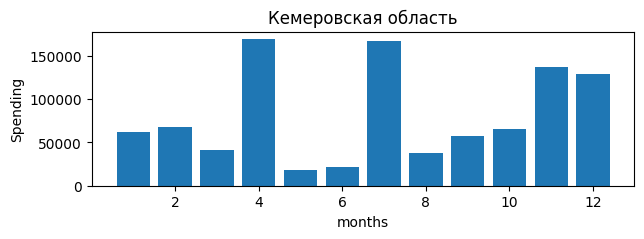

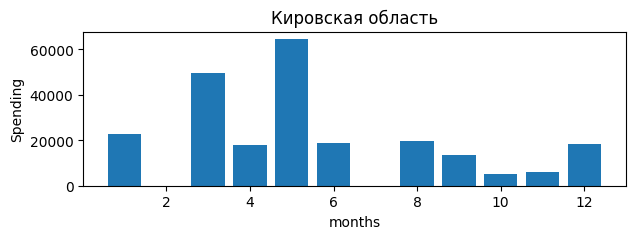

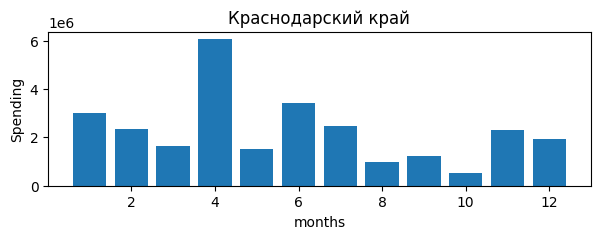

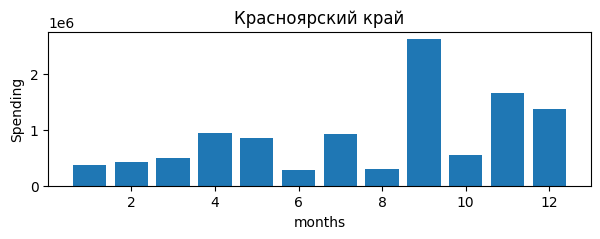

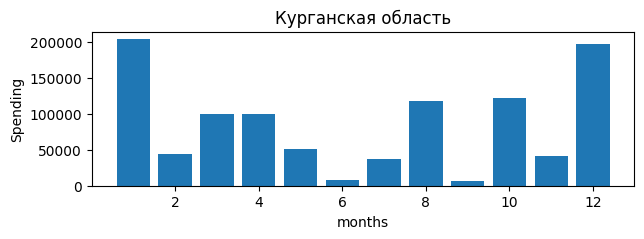

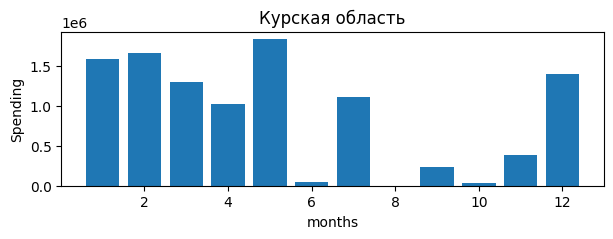

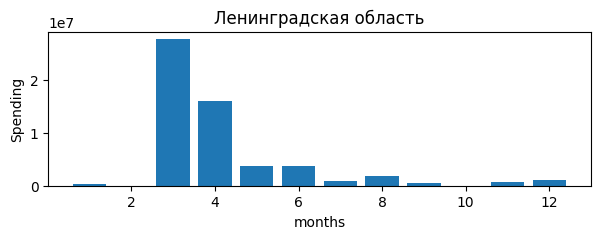

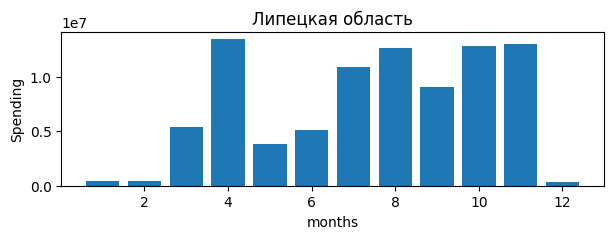

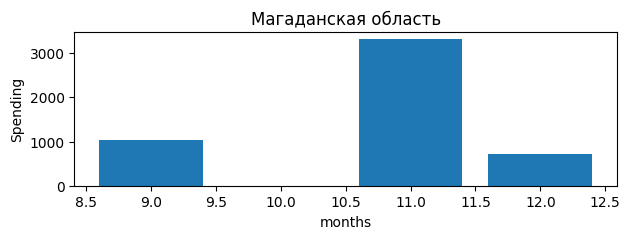

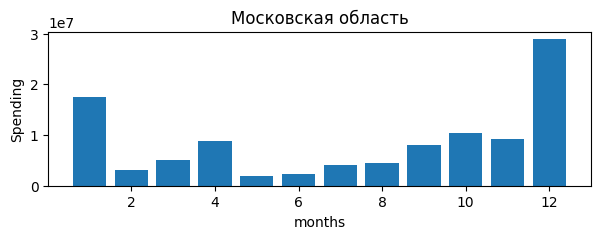

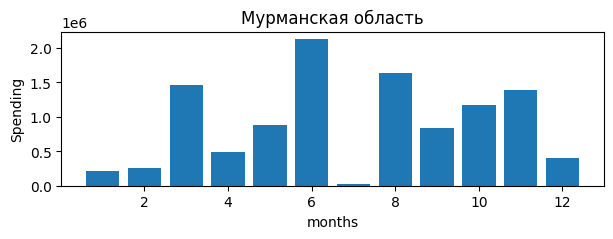

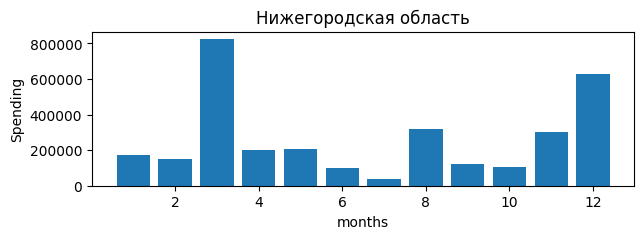

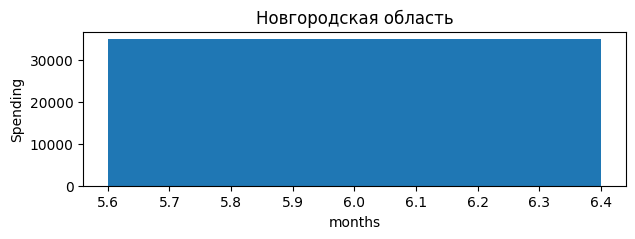

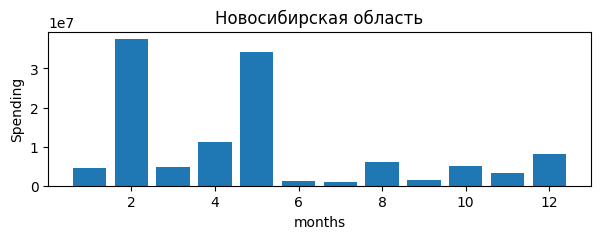

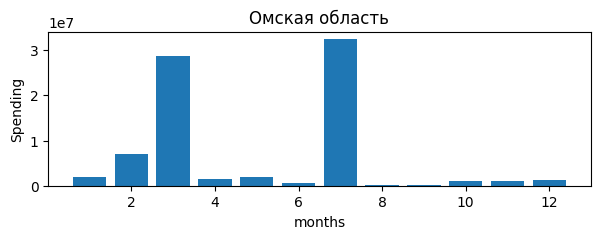

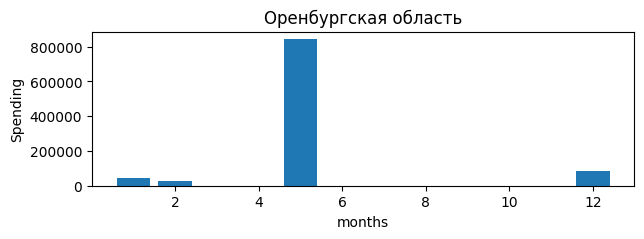

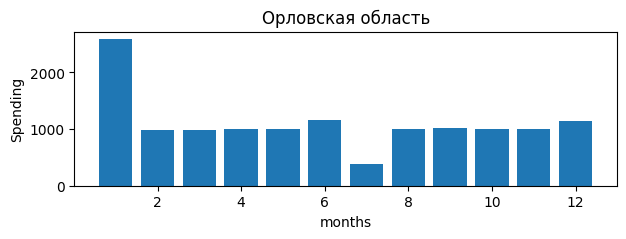

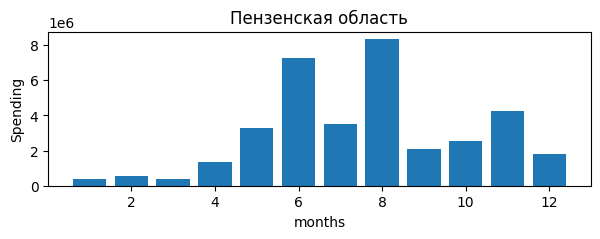

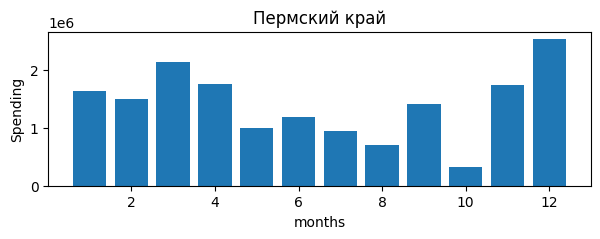

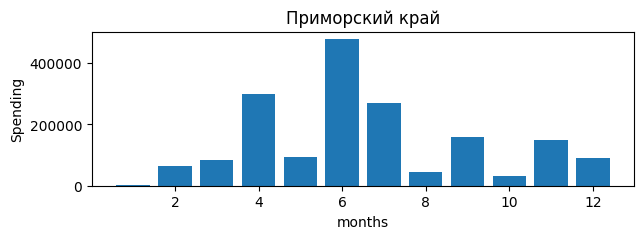

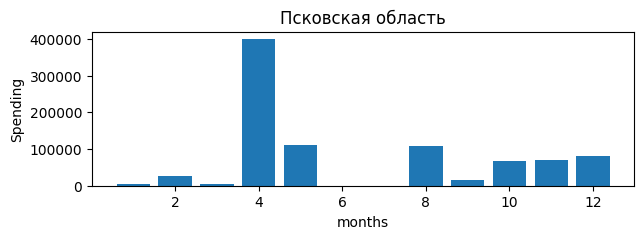

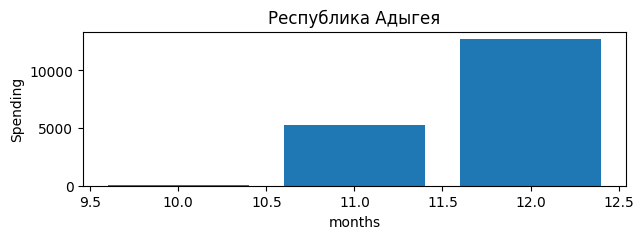

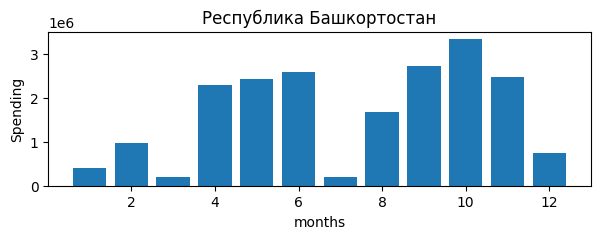

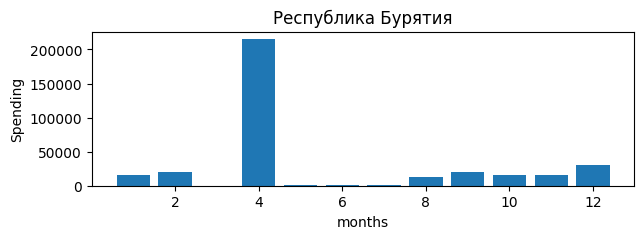

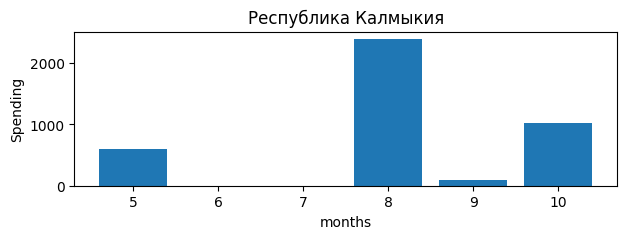

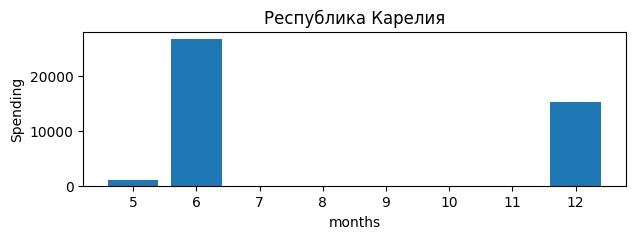

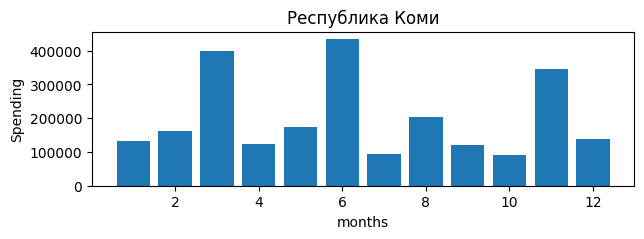

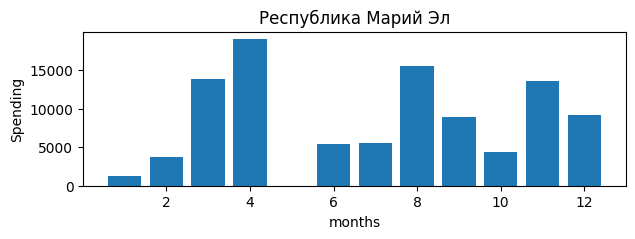

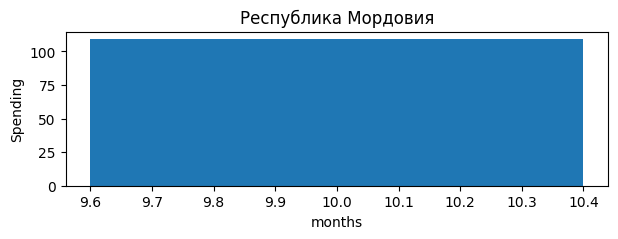

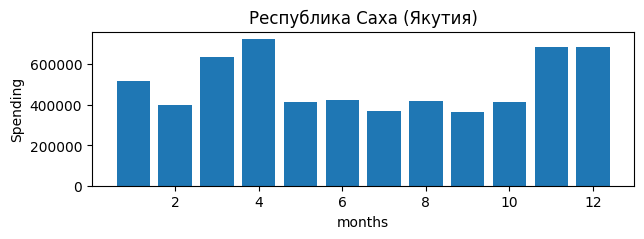

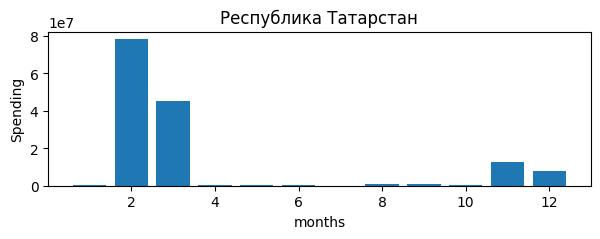

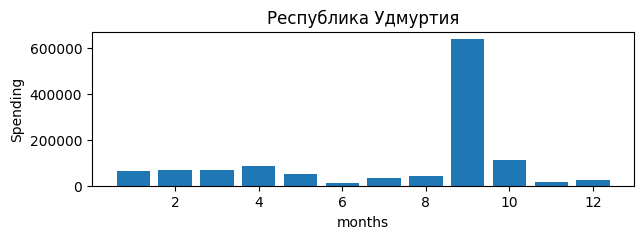

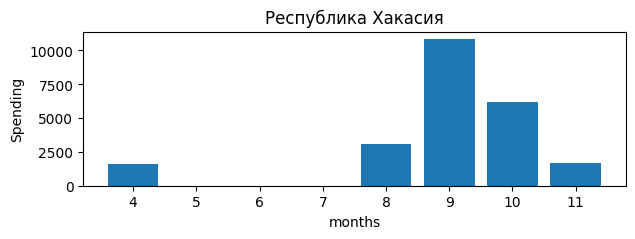

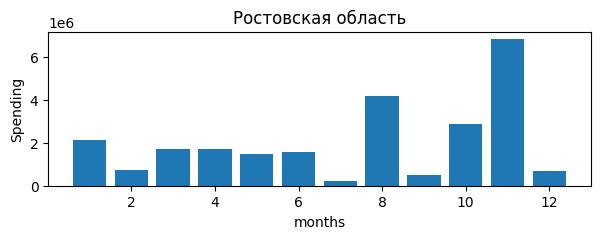

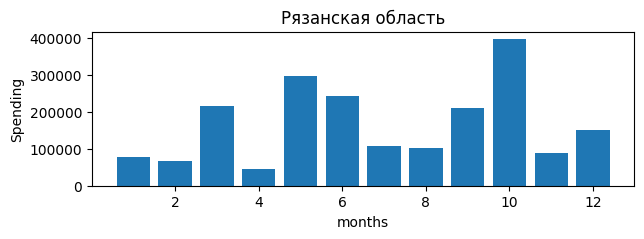

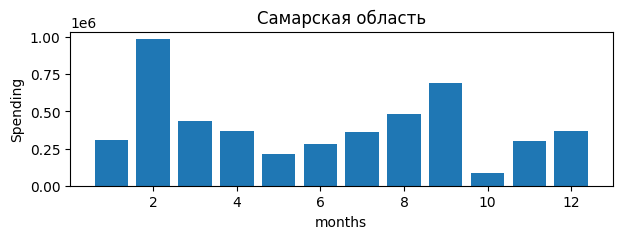

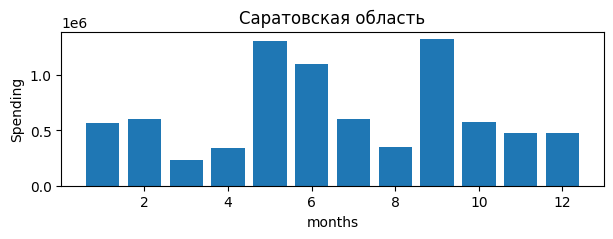

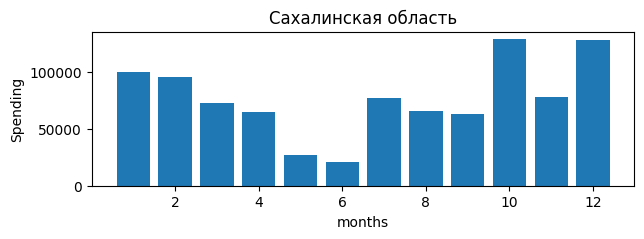

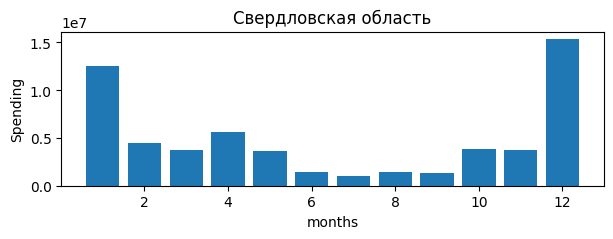

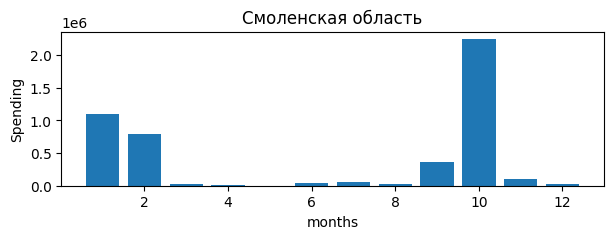

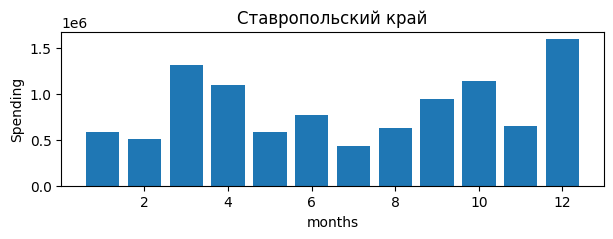

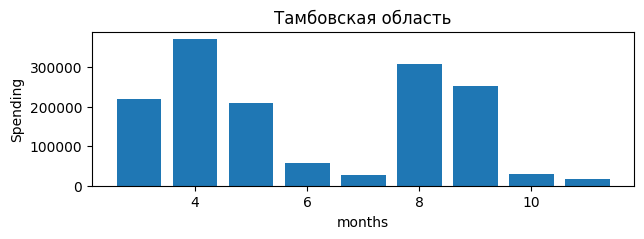

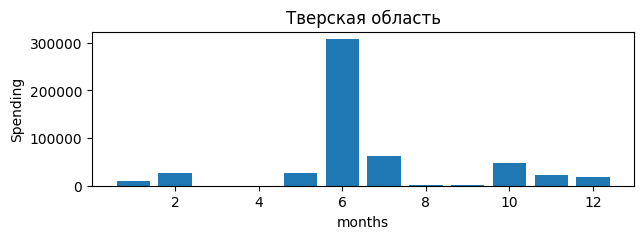

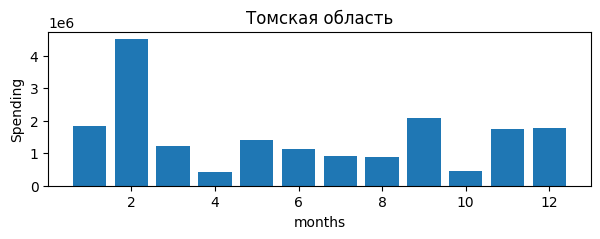

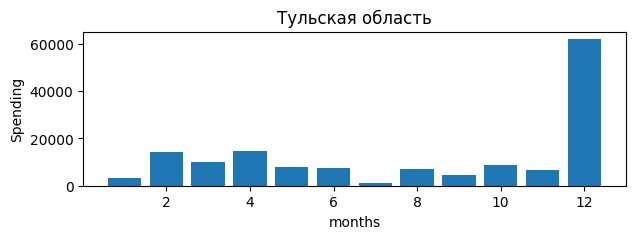

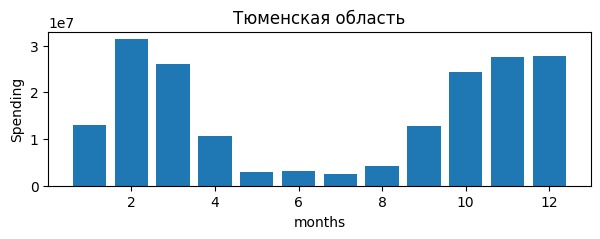

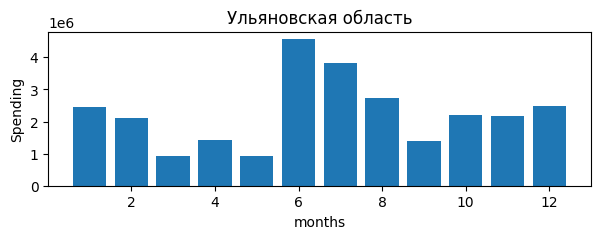

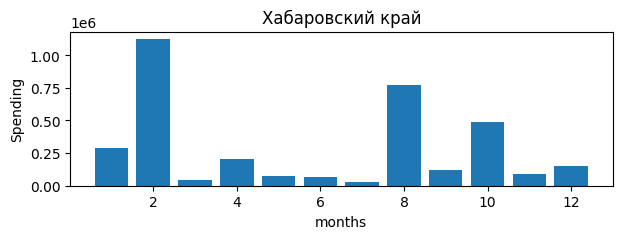

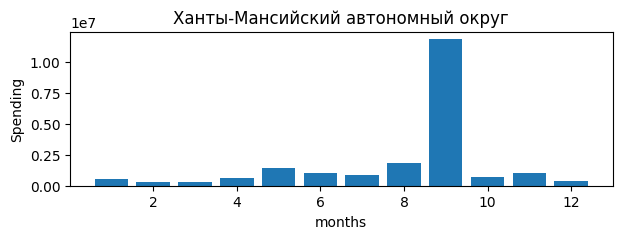

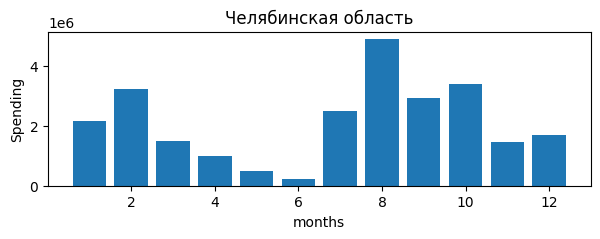

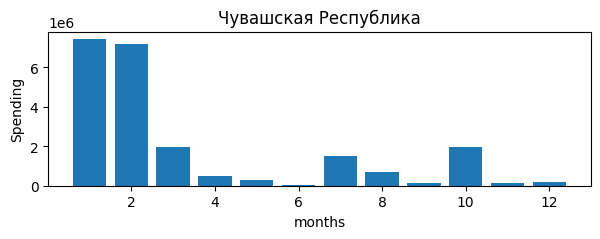

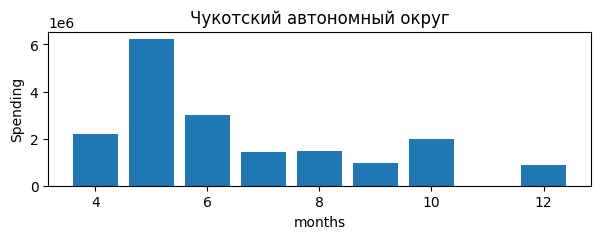

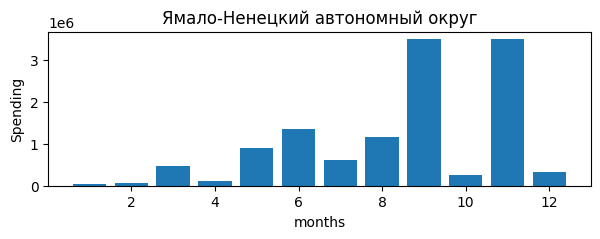

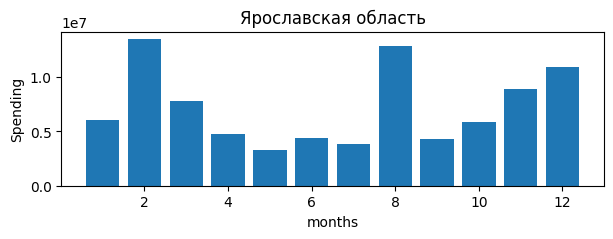

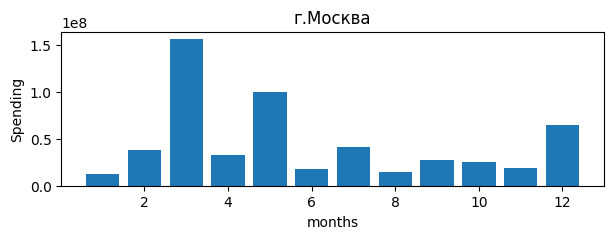

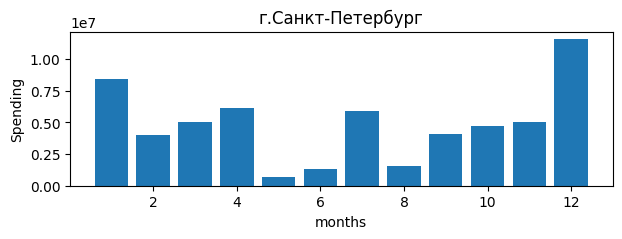

In [70]:
def dateConverter(d):
  yearDot = d.rfind('.')
  dateDot = d.find('.')
  return int(d[yearDot + 1:] + d[dateDot + 1:yearDot] + d[:dateDot])

def getMonth(d):
  yearDot = d.rfind('.')
  dateDot = d.find('.')
  return int(d[dateDot + 1:yearDot])

d["Month"] = list(map(getMonth, d['Date']))

time_gr = d.groupby(["Region"])
for key, value in time_gr:
  reg = time_gr.get_group(key)
  plt.figure(figsize = (7, 2))
  plt.title(key)
  plt.xlabel("months")
  plt.ylabel("Spending")
  plt.bar(reg['Month'], reg['Spending'])
  plt.show()